# Load Data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("titanic").getOrCreate()
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/05 15:14:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/05 15:14:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
filepath = "/home/ubuntu/working/spark-examples/data/titanic_train.csv"
titanic_sdf = spark.read.csv(filepath, inferSchema=True, header=True)

titanic_sdf.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [3]:
titanic_sdf.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [4]:
titanic_sdf.createOrReplaceTempView("titanic")

# EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 생존자 수 확인하기

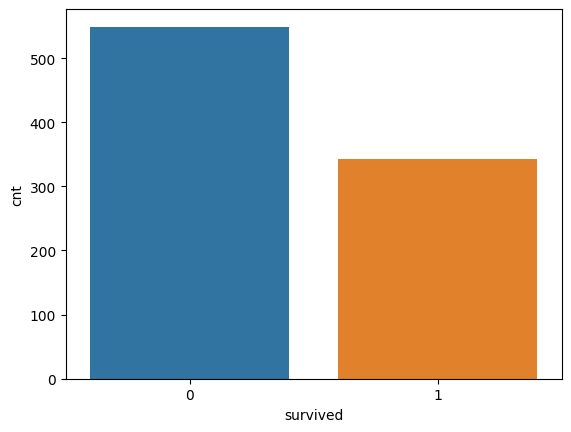

In [6]:
query = """
SELECT survived, count(*) as cnt
FROM titanic
GROUP BY survived
"""

sns.barplot(x='survived', y='cnt', data=spark.sql(query).toPandas())
plt.show()

## 2. Pclass 별 인원 파악하기

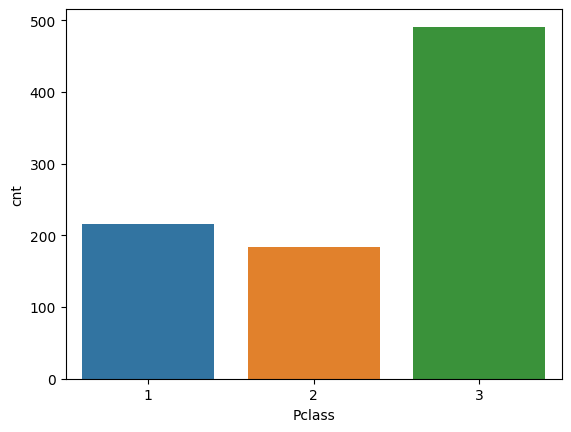

In [7]:
query = """
SELECT Pclass, count(*) as cnt
FROM titanic
GROUP BY Pclass
"""

sns.barplot(x='Pclass', y='cnt', data=spark.sql(query).toPandas())
plt.show()

### Pclass 별 생존/사망자 확인

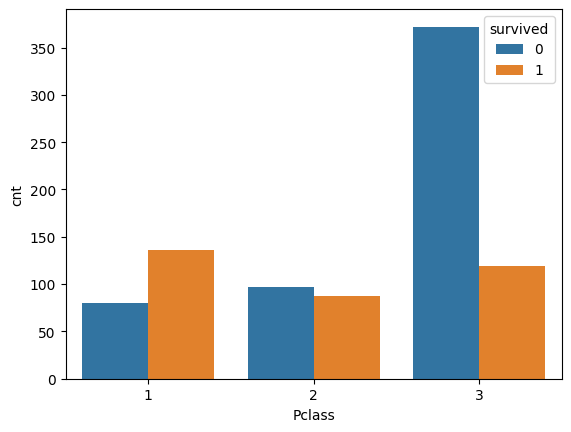

In [8]:
query = """
SELECT Pclass, survived, count(*) as cnt
FROM titanic
GROUP BY Pclass, survived
"""

sns.barplot(x='Pclass', y='cnt', hue='survived', data=spark.sql(query).toPandas())
plt.show()

## 3. 각 Cabin 별 탑승객 확인

In [9]:
query = """
SELECT Cabin, count(*) as cnt
FROM titanic
GROUP BY Cabin
"""
spark.sql(query).show()

+-------+---+
|  Cabin|cnt|
+-------+---+
|    A23|  1|
|    B79|  1|
|    E44|  2|
|  F E69|  1|
|    D28|  1|
|    C78|  2|
|    C95|  1|
|  F G73|  2|
|B58 B60|  2|
|     D7|  1|
|   C128|  1|
|    B39|  1|
|    B22|  2|
|   C110|  1|
|    D21|  1|
|     F2|  3|
|    B30|  1|
|   C104|  1|
|    B50|  1|
|     A6|  1|
+-------+---+
only showing top 20 rows



뒤의 숫자 때문에 정확히 각 구역 별 몇 명인지 알 수가 없을 것 같다. 앞에 알파벳만 가져오자

In [10]:
query = """
SELECT substr(Cabin, 0, 1) as section
FROM titanic
"""

spark.sql(query).show()

+-------+
|section|
+-------+
|   null|
|      C|
|   null|
|      C|
|   null|
|   null|
|      E|
|   null|
|   null|
|   null|
|      G|
|      C|
|   null|
|   null|
|   null|
|   null|
|   null|
|   null|
|   null|
|   null|
+-------+
only showing top 20 rows



null 값이 너무 많기 때문에 가장 많이 등장한 `section`으로 `null`을 처리

In [11]:
query = """
SELECT substr(Cabin, 0, 1) as section, survived, count(*) as cnt
FROM titanic
GROUP BY section, survived
ORDER BY section
"""

spark.sql(query).show()

+-------+--------+---+
|section|survived|cnt|
+-------+--------+---+
|   null|       1|206|
|   null|       0|481|
|      A|       0|  8|
|      A|       1|  7|
|      B|       0| 12|
|      B|       1| 35|
|      C|       1| 35|
|      C|       0| 24|
|      D|       1| 25|
|      D|       0|  8|
|      E|       1| 24|
|      E|       0|  8|
|      F|       0|  5|
|      F|       1|  8|
|      G|       0|  2|
|      G|       1|  2|
|      T|       0|  1|
+-------+--------+---+



C 구역의 인원이 가장 많기 때문에 Cabin 정보가 없는 사람은 임의로 `C` 구역으로 지정

In [12]:
import pyspark.sql.functions as F

titanic_sdf = titanic_sdf.withColumn("Section", F.substring(F.col("Cabin"), 0, 1))
titanic_sdf = titanic_sdf.fillna(value="C", subset=["Section"])
titanic_sdf.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Section|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|      C|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|      C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|      C|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|      C|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|      C|
|          6|   

각 Section 별로 몇 명이 살았는지 확인하기

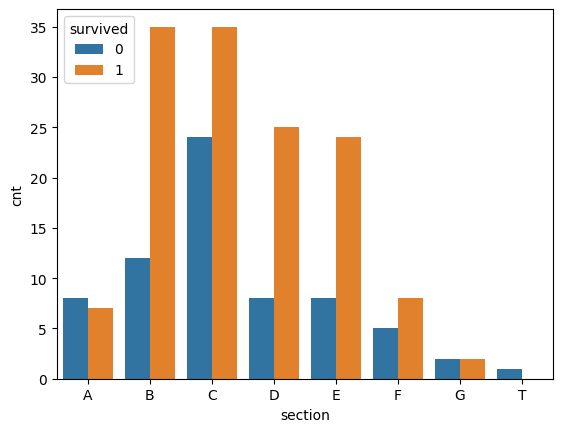

In [13]:
query = """
SELECT substr(Cabin, 0, 1) as section, survived, count(*) as cnt
FROM titanic
GROUP BY section, survived
ORDER BY section
"""

sns.barplot(x='section', y='cnt', hue='survived', data=spark.sql(query).toPandas())
plt.show()

## 4. 나이대 별 탑승자 확인

In [14]:
# udf 정의
def get_age_category(age):
    cat = ''
    
    if age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat


In [15]:
spark.udf.register("get_age_category", get_age_category)

<function __main__.get_age_category(age)>

In [16]:
# Age null 처리
import pyspark.sql.functions as F

avg_age = titanic_sdf.select(F.avg(F.col("Age")))
avg_age_row = avg_age.first()
avg_age_value = avg_age_row[0]

titanic_sdf = titanic_sdf.fillna(value=avg_age_value, subset=["Age"])
titanic_sdf.createOrReplaceTempView("titanic")

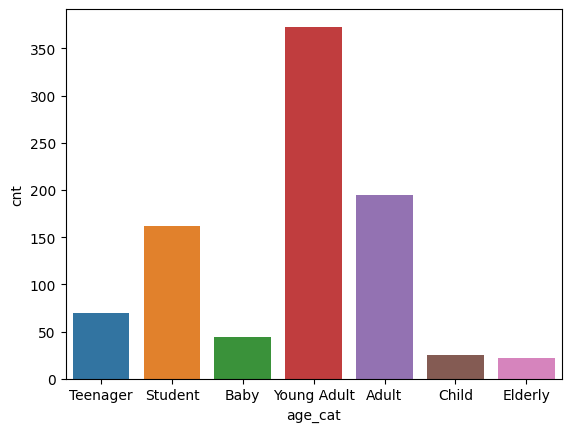

In [17]:
query = """
SELECT get_age_category(Age) as age_cat, count(*) as cnt
FROM titanic
GROUP BY age_cat
"""

sns.barplot(x='age_cat', y='cnt', data=spark.sql(query).toPandas())
plt.show()

### 나이대 별 생존자 확인

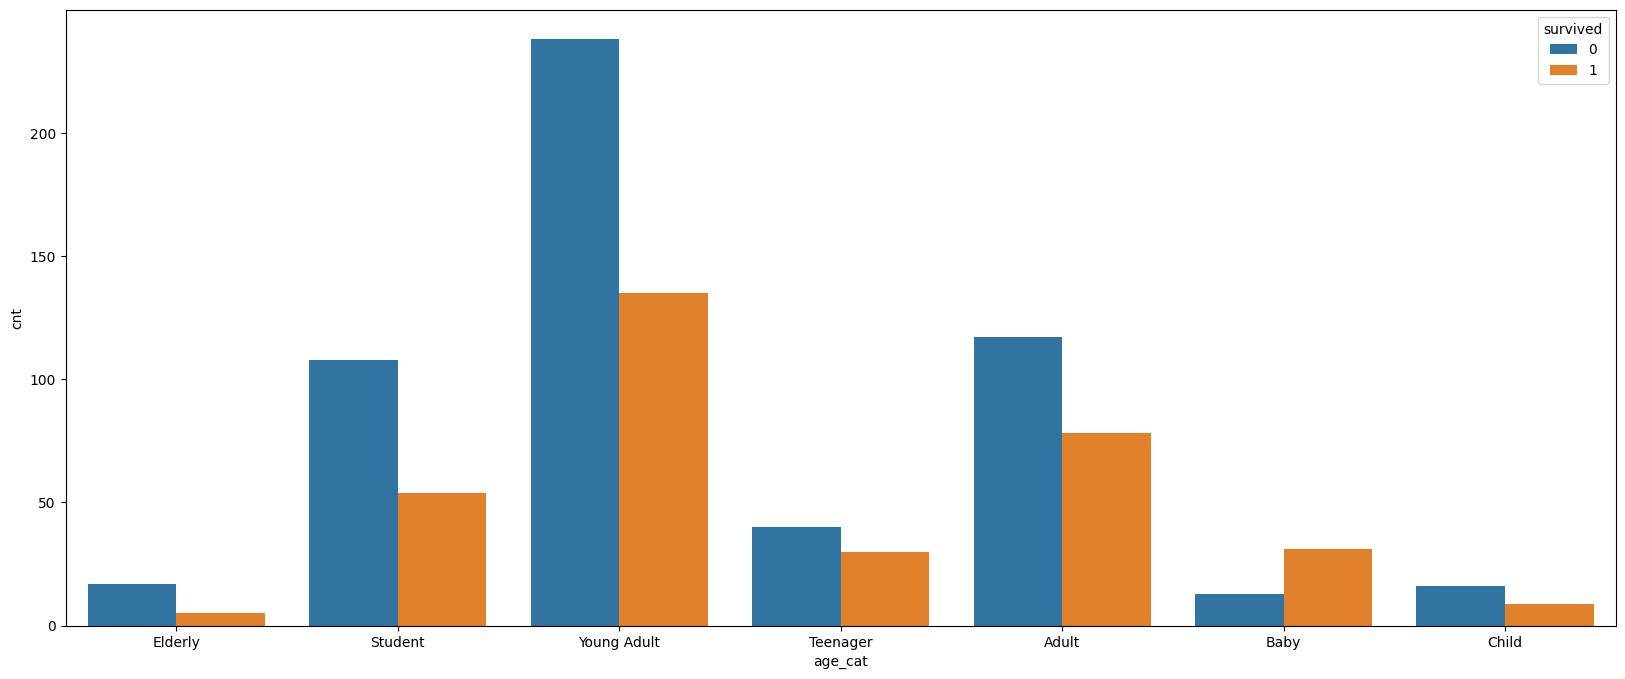

In [18]:
query = """
SELECT get_age_category(Age) as age_cat, survived, count(*) as cnt
FROM titanic
GROUP BY age_cat, survived
"""
plt.figure(figsize=(20, 8))
sns.barplot(x='age_cat', y='cnt', hue='survived', data=spark.sql(query).toPandas())
plt.show()

## 5. 동승자 수에 따른 생존자 확인

### 5-1. Parch, Sibsp 따로 분석하기

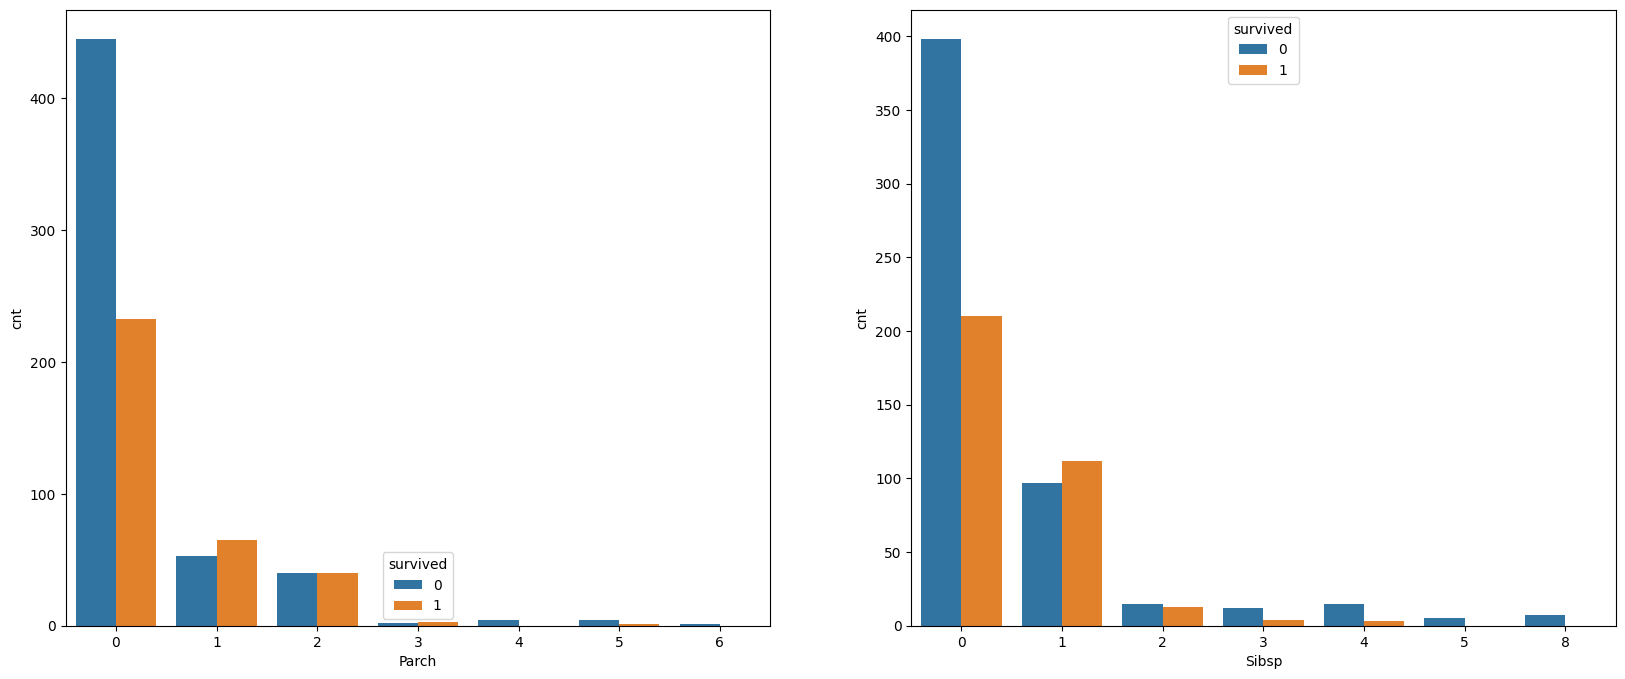

In [19]:
# Parch 별 생존자
parch_query = """
SELECT Parch, survived, count(*) as cnt
FROM titanic
GROUP BY Parch, survived
"""

# Sibsp 별 생존자
sibsp_query = """
SELECT Sibsp, survived, count(*) as cnt
FROM titanic
GROUP BY Sibsp, survived
"""

plt.figure(figsize=(20, 8))

plt.subplot(121)
sns.barplot(x='Parch', y='cnt', hue='survived', data=spark.sql(parch_query).toPandas())

plt.subplot(122)
sns.barplot(x='Sibsp', y='cnt', hue='survived', data=spark.sql(sibsp_query).toPandas())

plt.show()

### 5-2 `Parch` + `Sibsp`를 합쳐 `FamilySize` 구해서 확인하기
가족 구성원 자체가 많이 없을 수록 사망자가 압도적으로 높기 때문에 두 데이터를 합쳐서 확인하기

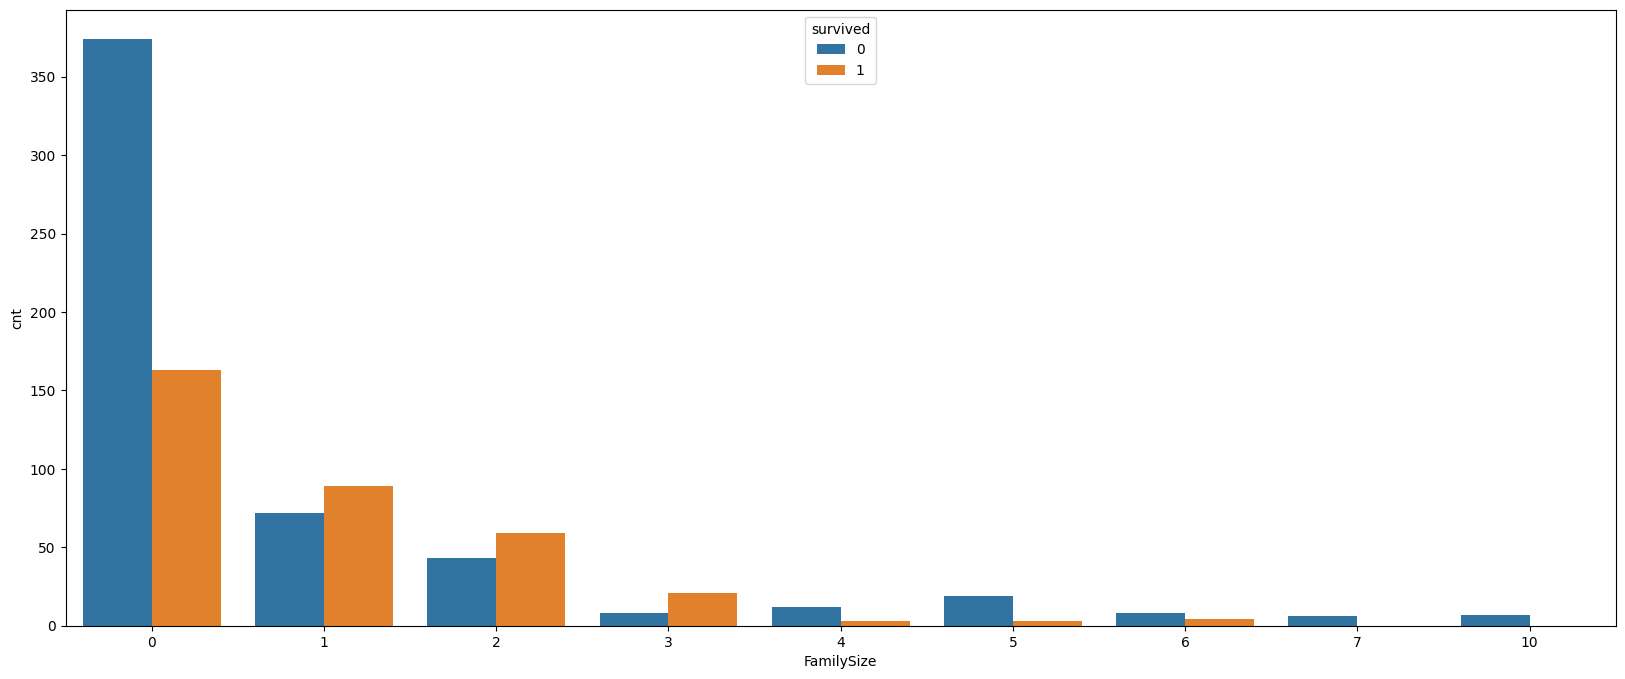

In [20]:
query = """
SELECT (Parch + Sibsp) as FamilySize, survived, count(*) as cnt
FROM titanic
GROUP BY FamilySize, survived
ORDER BY FamilySize
"""

plt.figure(figsize=(20, 8))

sns.barplot(x='FamilySize', y='cnt', hue='survived', data=spark.sql(query).toPandas())
plt.show()

## 6.성별 탑승자 및 사망/생존 여부 확인

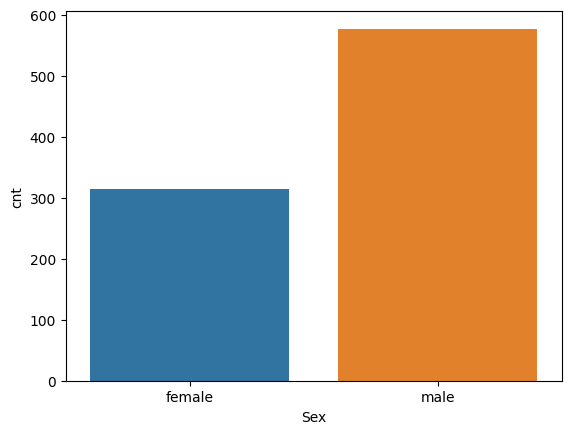

In [21]:
# 탑승자 확인.
query = """
SELECT Sex, count(*) as cnt
FROM titanic
GROUP BY Sex
"""

sns.barplot(x='Sex', y='cnt', data=spark.sql(query).toPandas())
plt.show()

남성이 더 많이 탑승했다는 것을 확인. 생존 및 사망자도 확인

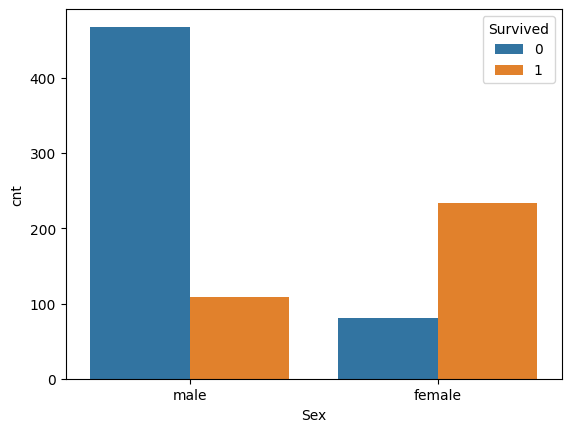

In [22]:
# 탑승자 확인.
query = """
SELECT Sex, Survived, count(*) as cnt
FROM titanic
GROUP BY Sex, Survived
"""

sns.barplot(x='Sex', y='cnt', hue='Survived', data=spark.sql(query).toPandas())
plt.show()

남성의 사망자 수가 압도적으로 높다는 것을 알 수 있음.

## 7.탑승지 별 탑승수, 사망/생존자 확인

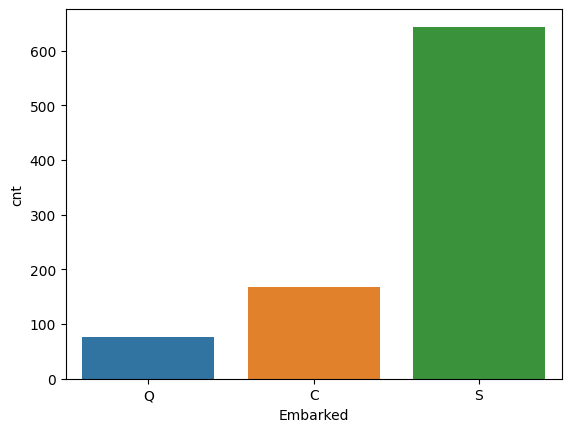

In [23]:
# 탑승자 확인.
query = """
SELECT Embarked, count(*) as cnt
FROM titanic
GROUP BY Embarked
"""

sns.barplot(x='Embarked', y='cnt', data=spark.sql(query).toPandas())
plt.show()

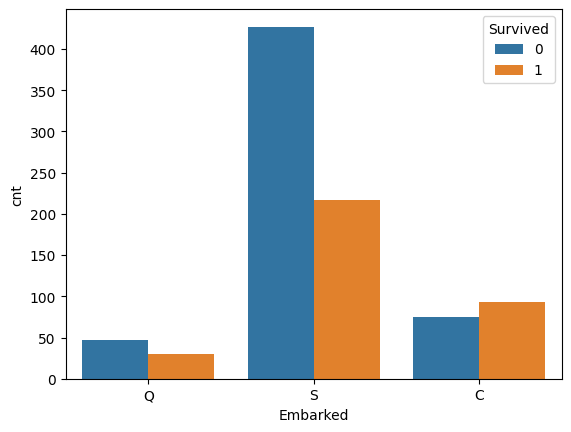

In [24]:
# 탑승지 별 생존/사망 확인
query = """
SELECT Embarked, Survived, count(*) as cnt
FROM titanic
GROUP BY Embarked, Survived
"""

sns.barplot(x='Embarked', y='cnt', hue='Survived', data=spark.sql(query).toPandas())
plt.show()

## 8. 요금 및 나이에 따른 생존자 확인

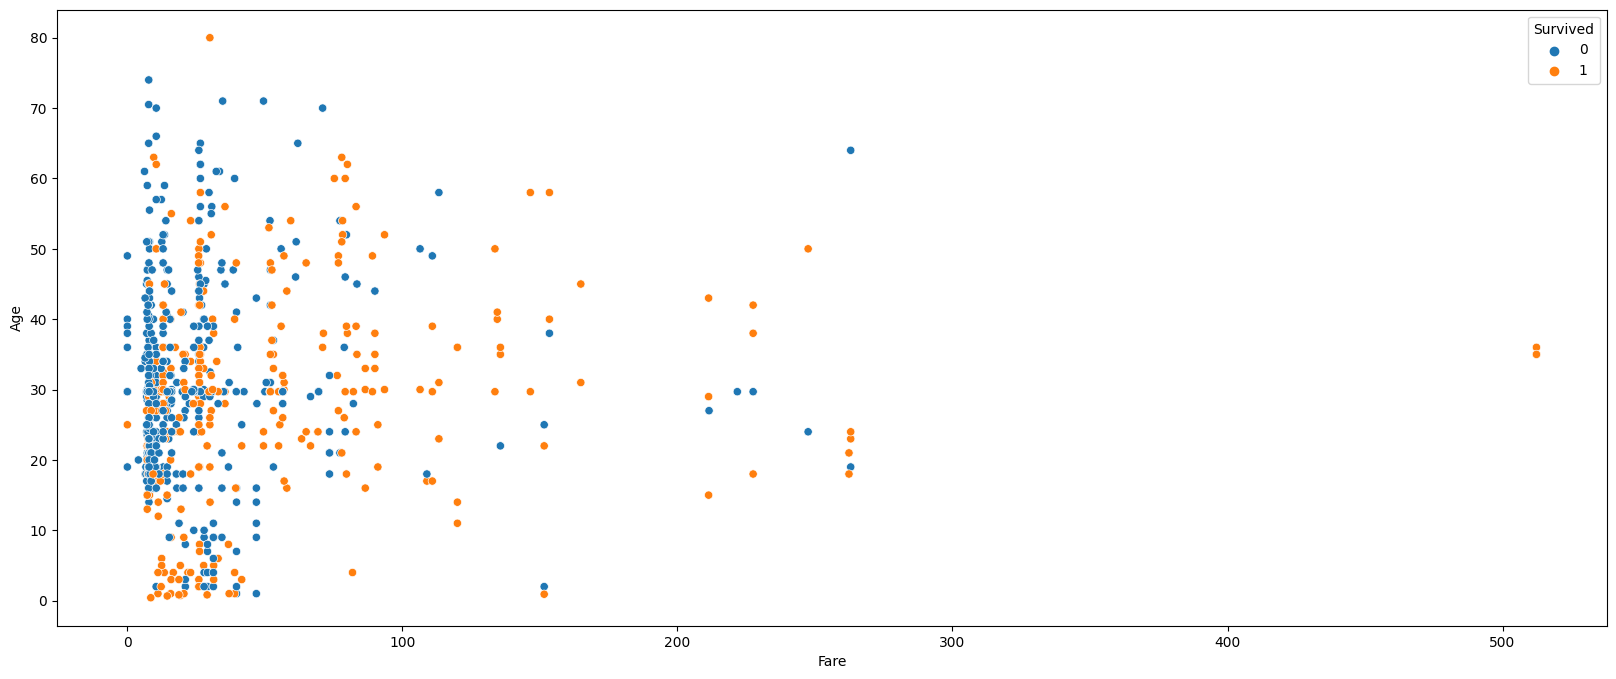

In [25]:
query = """
SELECT Fare, Age, Survived
FROM titanic
"""

plt.figure(figsize=(20, 8))
sns.scatterplot(x='Fare', y='Age', hue='Survived', data = spark.sql(query).toPandas())
plt.show()

500 달러 이상을 낸 Outlier가 발견되었음. 제거하고 확인(200달러 미만)

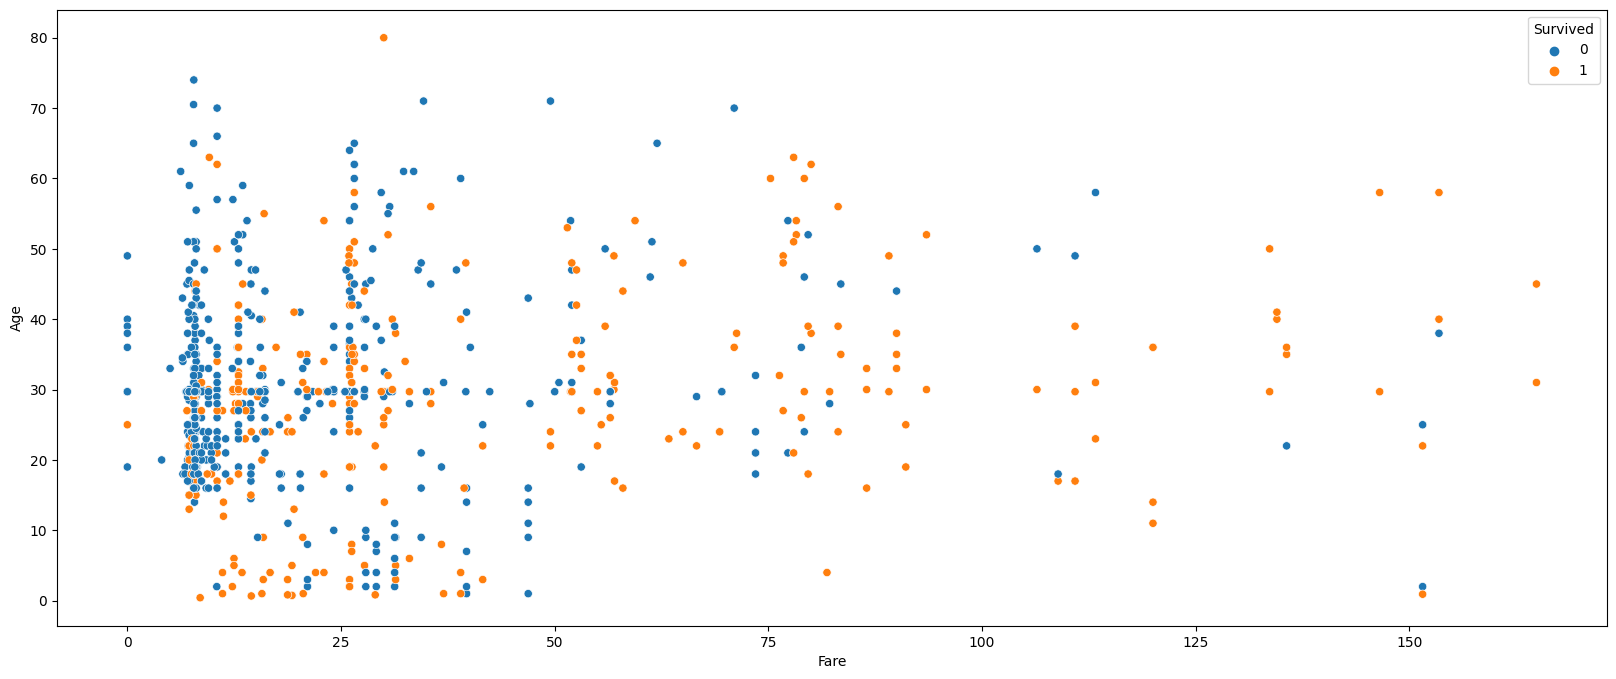

In [26]:
query = """
SELECT Fare, Age, Survived
FROM titanic
WHERE Fare < 200
"""

plt.figure(figsize=(20, 8))
sns.scatterplot(x='Fare', y='Age', hue='Survived', data = spark.sql(query).toPandas())
plt.show()

대체적으로 요금을 많이 내고, 나이가 어릴 수록 생존자가 많음을 확인 할 수 있다.

# 머신러닝 모델 생성

## 전처리 파이프라인 생성
- 전처리 파이프라인 생성 전 null 값 여부를 먼저 확인

In [27]:
titanic_sdf.select(
    [ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in titanic_sdf.columns ]
).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Section|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       2|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+



Cabin은 Section으로 대체 되었고, Embarked의 null 값은 `S`로 채우기

In [28]:
titanic_sdf = titanic_sdf.fillna("S", subset=["Embarked"])
titanic_sdf.select(
    [ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in titanic_sdf.columns ]
).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Section|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+



In [29]:
# 필요한 컬럼만 추출하기
query="""
SELECT Survived,
       Pclass,
       Sex,
       Age,
       (Parch + Sibsp) as FamilySize,
       Fare,
       Embarked,
       Section
FROM titanic
"""

data_df = spark.sql(query)
data_df.show()

+--------+------+------+-----------------+----------+-------+--------+-------+
|Survived|Pclass|   Sex|              Age|FamilySize|   Fare|Embarked|Section|
+--------+------+------+-----------------+----------+-------+--------+-------+
|       0|     3|  male|             22.0|         1|   7.25|       S|      C|
|       1|     1|female|             38.0|         1|71.2833|       C|      C|
|       1|     3|female|             26.0|         0|  7.925|       S|      C|
|       1|     1|female|             35.0|         1|   53.1|       S|      C|
|       0|     3|  male|             35.0|         0|   8.05|       S|      C|
|       0|     3|  male|29.69911764705882|         0| 8.4583|       Q|      C|
|       0|     1|  male|             54.0|         0|51.8625|       S|      E|
|       0|     3|  male|              2.0|         4| 21.075|       S|      C|
|       1|     3|female|             27.0|         2|11.1333|       S|      C|
|       1|     2|female|             14.0|         1

In [30]:
stages = []

### OneHotEncoding
- Pclass, Sex, Embarked, Section은 OneHotEncoding 처리를 수행해야 한다.

In [31]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

cat_features = [
    "Pclass"
    "Sex",
    "Embarked",
    "Section"
]

for c in cat_features:
    cat_indexer = StringIndexer(inputCol=c, outputCol=c+"_idx").setHandleInvalid("keep")
    onehot_encoder = OneHotEncoder(inputCols=[cat_indexer.getOutputCol()], outputCols=[c+"_onehot"])
    stages += [cat_indexer, onehot_encoder]

stages

[StringIndexer_22437ea8f649,
 OneHotEncoder_48444e61b3c1,
 StringIndexer_32533d0a4080,
 OneHotEncoder_37d52fab0507,
 StringIndexer_dcc654ca4cbf,
 OneHotEncoder_5008c21e283f]

### StandardScaling
- FamilySize, Fare는 Standard Scaling 처리를 수행한다.

In [32]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

num_features = [
    "FamilySize",
    "Fare",
]

for n in num_features:
    num_assembler = VectorAssembler(inputCols=[n], outputCol=n+"_vector")
    num_scaler = StandardScaler(inputCol=num_assembler.getOutputCol(), outputCol=n+"_scaled")
    
    stages += [num_assembler, num_scaler]

stages

[StringIndexer_22437ea8f649,
 OneHotEncoder_48444e61b3c1,
 StringIndexer_32533d0a4080,
 OneHotEncoder_37d52fab0507,
 StringIndexer_dcc654ca4cbf,
 OneHotEncoder_5008c21e283f,
 VectorAssembler_44285dfab36c,
 StandardScaler_640732e8c2dc,
 VectorAssembler_dd60ac4038ef,
 StandardScaler_657213da93b8]

In [33]:
assemble_inputs = [c + "_onehot" for c in cat_features] + [n + "_scaled" for n in num_features]
assemble_inputs

['PclassSex_onehot',
 'Embarked_onehot',
 'Section_onehot',
 'FamilySize_scaled',
 'Fare_scaled']

In [34]:
total_assembler = VectorAssembler(inputCols=assemble_inputs, outputCol='features')
stages.append(total_assembler)
stages

[StringIndexer_22437ea8f649,
 OneHotEncoder_48444e61b3c1,
 StringIndexer_32533d0a4080,
 OneHotEncoder_37d52fab0507,
 StringIndexer_dcc654ca4cbf,
 OneHotEncoder_5008c21e283f,
 VectorAssembler_44285dfab36c,
 StandardScaler_640732e8c2dc,
 VectorAssembler_dd60ac4038ef,
 StandardScaler_657213da93b8,
 VectorAssembler_20893e7b7db5]

## 훈련 / 테스트 데이터 세트 생성

In [35]:
train_df, test_df = data_df.randomSplit([0.8, 0.2], seed=42)

## 파이프라인 생성

In [36]:
# 파이프라인 등록
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipeline

Pipeline_e969ff266572

## 파이프라인을 이용한 데이터 변환

In [37]:
# fit
fitted_transformer = pipeline.fit(train_df)
fitted_transformer

Py4JJavaError: An error occurred while calling o314.fit.
: org.apache.spark.SparkException: Input column PclassSex does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
vec_train_df = fitted_transformer.transform(train_df)
vec_train_df.printSchema()

## 모델 생성

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    maxIter=50,
    labelCol='Survived',
    featuresCol='features',
    regParam=0.1
)

lr

In [ ]:
model = lr.fit(vec_train_df)
model

# 테스트 데이터 예측

In [ ]:
# test_df 변환
vec_test_df = fitted_transformer.transform(test_df)
vec_test_df.printSchema()

In [ ]:
# vec_test_df로 예측
predictions = model.transform(vec_test_df)
predictions.select("features", "Survived", "prediction").show()

# 평가

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol = 'Survived',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

accuracy = evaluator_accuracy.evaluate(predictions)
accuracy

In [ ]:
spark.stop()